### The easiest way to run this notebook is use Docker. 

See instructions here [https://github.com/EarthByte/spatial-temporal-exploration/blob/master/README.md#docker](https://github.com/EarthByte/spatial-temporal-exploration/blob/master/README.md#docker)

## Step 1: 
#### Generate Subduction Convergence Kinematics Statistics 

The [convergence.py](convergence.py) depends on the PlateTectonicTools, which can be found at [https://github.com/EarthByte/PlateTectonicTools.git](https://github.com/EarthByte/PlateTectonicTools.git).
    

The configuration parameters for convergence.py can be found in [parameters.py](parameters.py).

Relevant parameters:
* plate_tectonic_tools_path -- the path to the PlateTectonicTools code
* rotation_files -- location of the rotation files
* topology_files -- location of the topology files
* threshold_sampling_distance_degrees -- the default threshold sampling distance along trenches (subduction zones)
* time.start -- start time
* time.end -- end time
* time.step -- time interval between steps
* velocity_delta_time -- time interval for velocity calculation
* anchor_plate_id - the anchor plate id
* convergence_data_filename_prefix -- the prefix of the output files
* convergence_data_filename_ext -- the extension name of the output files
* convergence_data_dir -- the name of the folder in which the output files go


In [7]:
%%capture --no-stdout

import subprocess
import convergence 

print('running convergence...')
print('this may take a while, be patient...')
print('')

#run the convergence script
#this will generate a bunch of Subduction Convergence Kinematics Statistics files
#by default the files are placed in ./convergence_data
convergence.run_it()

# now, let's list all the output files
o = subprocess.check_output(['ls', '-ltlh', './convergence_data'])
print(str(o).replace('\\n','\n')[2:-2])


running convergence...
this may take a while, be patient...

{ 'anchor_plate_id': 0,
  'convergence_data_dir': './convergence_data/',
  'convergence_data_filename_ext': 'csv',
  'convergence_data_filename_prefix': 'subStats',
  'grid_files': [ './AgeGrids/EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid-{time:d}.nc'],
  'input_file': 'coregistration_input_data_example.csv',
  'output_dir': 'coreg_output',
  'plate_tectonic_tools_path': '../../PlateTectonicTools/ptt/',
  'regions': [5, 10],
  'rotation_files': ['../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'],
  'threshold_sampling_distance_degrees': 0.2,
  'time': {'end': 230, 'start': 0, 'step': 1},
  'topology_files': [ '../data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                      '../data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz'],
  'vector_files': ['./convergence_data/subStats_{time:.2f}.csv'],
  'velocity_delta_time': 1}

Convergence completed successfully!
The result data

#### The columns in the csv files are:

* 0 lon
* 1 lat
* 2 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 3 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 4 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 5 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 6 length of arc segment (in degrees) that current point is on
* 7 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 8 subducting plate ID
* 9 trench plate ID
* 10 distance (in degrees) along the trench line to the nearest trench edge
* 11 the distance (in degrees) along the trench line from the start edge of the trench
* 12 convergence velocity orthogonal (in cm/yr)
* 13 convergence velocity parallel  (in cm/yr) 
* 14 the trench plate absolute velocity orthogonal (in cm/yr)
* 15 the trench plate absolute velocity orthogonal (in cm/yr)
* 16 the subducting plate absolute velocity magnitude (in cm/yr)
* 17 the subducting plate absolute velocityobliquity angle (in degrees)
* 18 the subducting plate absolute velocity orthogonal       
* 19 the subducting plate absolute velocity parallel

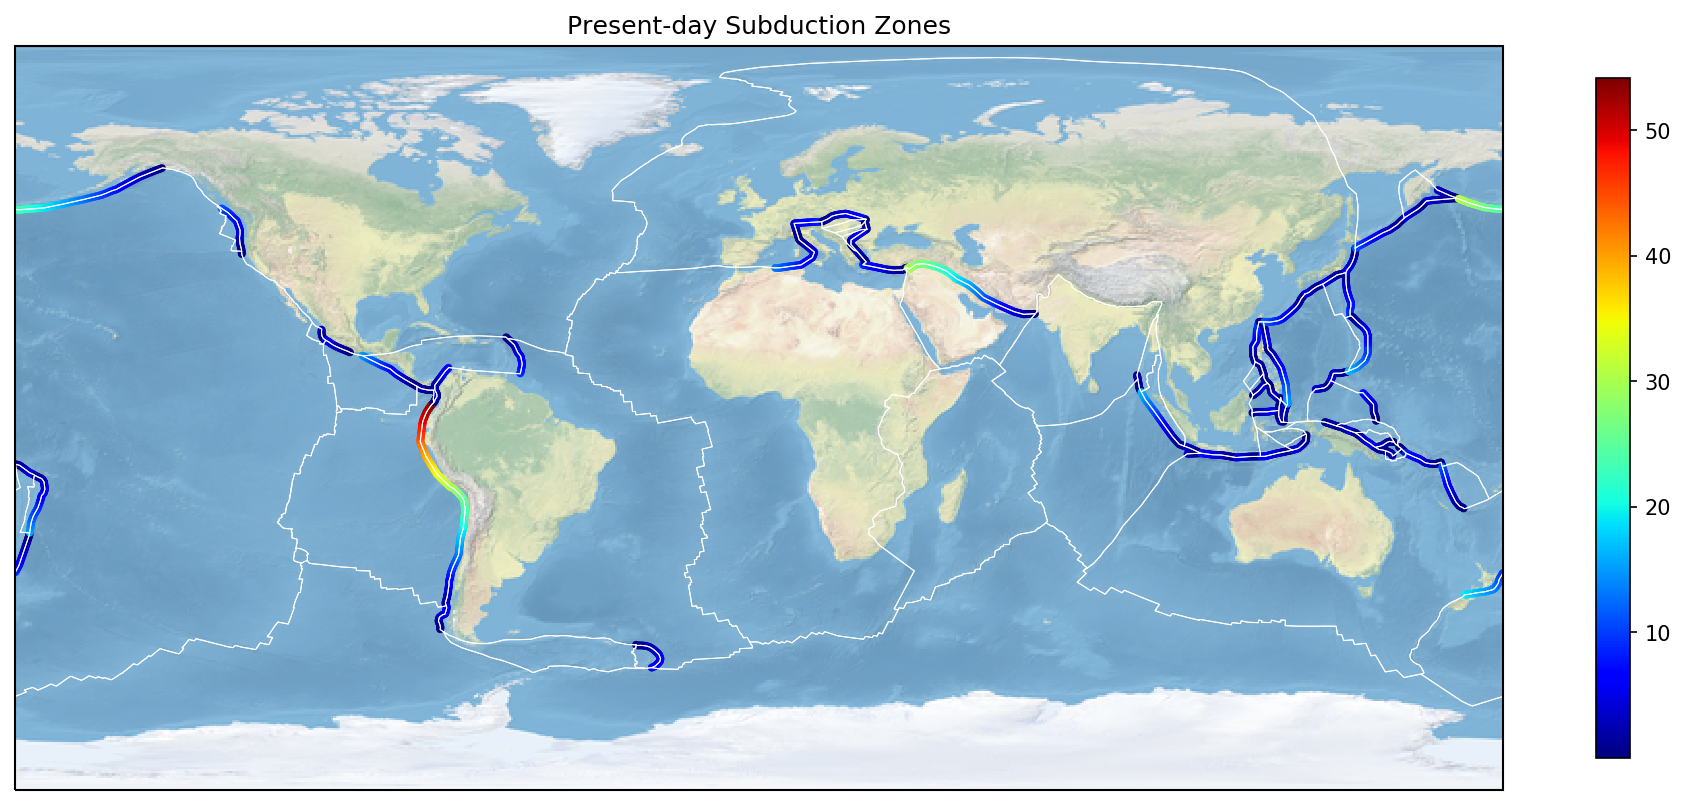

In [8]:
%matplotlib inline

import requests, os

import pygplates

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

#now we plot the Subduction Convergence Kinematics Statistics in a map

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

#change this number to see the trench colored by different property. 
#The meaning of this number can be found in the cell above
color_by = 11

#now, get topological plates boundaries
data_dir = '../data/'
rotation_model = pygplates.RotationModel(data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS.rot')
topology_features = [data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                     data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz']

time = 0
resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, 
                             shared_boundary_sections)

geoms = []           
for t in resolved_topologies:
    geoms.append(t.get_resolved_boundary())

#now, plot the data in a map    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
for geom in geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='white', linewidth=.5, #the topological plates boundaries in white
         transform=ccrs.Geodetic(),
    )
#the subduction sample points are colored by property value. see "color_by" above
cb=ax.scatter(trench_data[:,0], trench_data[:,1], 30, marker='.', c=trench_data[:,color_by], cmap=plt.cm.jet)
plt.title('Present-day Subduction Zones')
fig.colorbar(cb, shrink=0.5)
plt.show()

#### Plot a reconstruction map
This is a reconstructed map with a paleo-age grid, paleo-coastlines, plate boundaries and subduction teeth.

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    title: Produced by grdmath
    history: grdmath /Volumes/izanagi/Agegrids/AREPS_CORRECTED/NoMask/agegrid_final_nomask_10.nc /Volumes/izanagi/COBs/AREPS_CORRECTED/GMT5_GRD/cobmask_global_10.nc OR = /Volumes/izanagi/Agegrids/AREPS_CORRECTED/Mask/agegrid_final_mask_10.nc
    GMT_version: 6.0.0_b03d6d7_2019.03.06 [64-bit]
    dimensions(sizes): lon(3601), lat(1801)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float32 z(lat,lon)
    groups: 



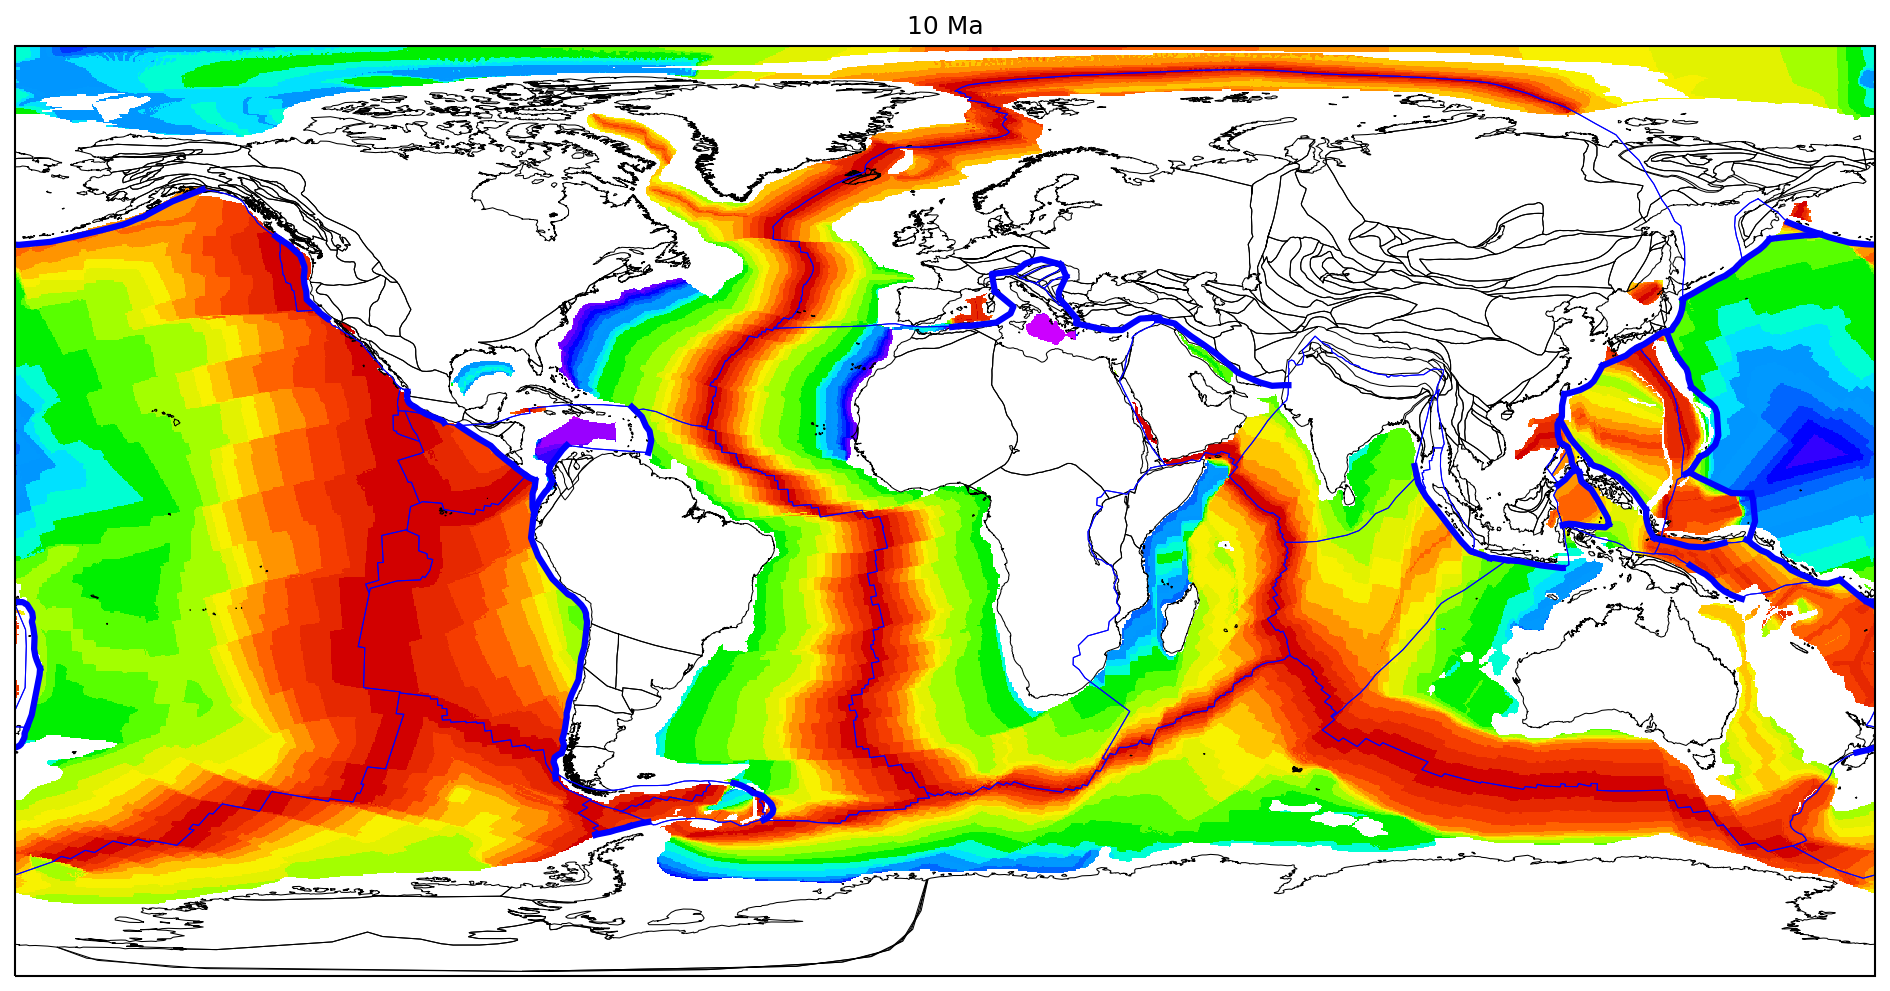

In [17]:
import requests, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from netCDF4 import Dataset

import Utils, pygplates

time = 10

if not os.path.isdir('./AgeGrids'):
    os.system('mkdir AgeGrids')
  
# download the age grid if necessary
url_temp='https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2016_AREPS/Muller_etal_2016_AREPS_Agegrids/Muller_etal_2016_AREPS_Agegrids_v1.15/netCDF-4_0-230Ma/EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid-{}.nc'
file_temp='./AgeGrids/EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid-{}.nc'
agegrid_file = file_temp.format(time)
print('Downloading age grids...')
if not os.path.isfile(agegrid_file):
    myfile = requests.get(url_temp.format(time))
    open(agegrid_file, 'wb').write(myfile.content)
 
agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')

#reconstruct coastlines and topology
data_dir = '../data/'
rotation_model = pygplates.RotationModel(data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS.rot')
topology_features = [data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                     data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz']

resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, 
                             shared_boundary_sections)

reconstructed_geometries = []
pygplates.reconstruct(
                data_dir + 'Shapefiles/Coastlines/Global_coastlines_2015_v1_low_res.shp', 
                rotation_model, 
                reconstructed_geometries, 
                time, 0)

subduction_geoms=[]
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() != pygplates.FeatureType.gpml_subduction_zone:
            continue
    for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
        subduction_geoms.append(shared_sub_segment.get_resolved_geometry())

# plot the map
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

ax.set_global()
img = Dataset(agegrid_file)
print(img)
ax.imshow(np.roll(img.variables['z'],1800), origin='lower', transform=ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90], cmap=agegrid_cmap)

for geom in reconstructed_geometries:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='black', linewidth=.5, #the topological plates boundaries in black
         transform=ccrs.Geodetic(),
    )

for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=.5, #the topological plates boundaries in black
         transform=ccrs.Geodetic(),
    )
    
for geom in subduction_geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=3, #the topological plates boundaries in black
         transform=ccrs.Geodetic(),
    )
    
    
plt.title(f'{time} Ma')
plt.show()   
   


#### This is the end of step 1 and now open the step 2 notebook
[2_Prepare_Input_File_For_Coregistration.ipynb](2_Prepare_Input_File_For_Coregistration.ipynb)